# Gold Recovery from Ore



The aim of this project is to create a prototype of a machine learning model for "Цифра" (Digit) company. The company develops solutions for efficient operations of industrial enterprises.

The model should predict the gold recovery coefficient from gold-containing ore using data on extraction and purification parameters.

The model will help optimize production to avoid launching enterprises with unprofitable characteristics.

**Project Stages:**

- Data preparation;
- Conducting exploratory data analysis;
- Building and training the model.

**Data Description**

Technological Process

- Rougher feed - original raw material
-Rougher additions (or reagent additions) - flotation reagents: Xanthate, Sulphate, Depressant
- Xanthate - xanthogenate (promoter or flotation activator);
- Sulphate - sulfate (sodium sulfide in this production);
- Depressant - depressant (sodium silicate).
- Rougher process - flotation
- Rougher tails - tailings
- Float banks - flotation plant
- Cleaner process - purification
- Rougher Au - rough gold concentrate
- Final Au - final gold concentrate

Parameters of Stages

- air amount - volume of air
- fluid levels - liquid level
- feed size - size of raw material particles
- feed rate - feed rate

## Data preparation

In [1]:
pip install missingno

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import (mean_absolute_error, mean_squared_error, make_scorer)
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from numpy.random import RandomState
import missingno as msno
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import  make_pipeline
from sklearn.dummy import DummyRegressor
import warnings

/usr/local/lib/python3.10/dist-packages/sklearn/experimental/enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


In [3]:
RANDOM_STATE = RandomState(12345)

In [4]:
pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")

### Let's take a look at the data

In [5]:
try:
    url_full = "https://code.s3.yandex.net/datasets/gold_recovery_full_new.csv"
    url_train = "https://code.s3.yandex.net/datasets/gold_recovery_train_new.csv"
    url_test = "https://code.s3.yandex.net/datasets/gold_recovery_test_new.csv"

    full_data = pd.read_csv(url_full, index_col="date")
    train_data = pd.read_csv(url_train, index_col="date")
    test_data = pd.read_csv(url_test, index_col="date")
except:
    full_data = pd.read_csv("/datasets/gold_recovery_full_new.csv", index_col="date")
    train_data = pd.read_csv("/datasets/gold_recovery_train_new.csv", index_col="date")
    test_data = pd.read_csv("/datasets/gold_recovery_test_new.csv", index_col="date")

In [6]:
all_data = [full_data, train_data, test_data]

In [7]:
def get_data_info(data):
    display(data.info())
    display("SAMPLE:", data.sample(10))
    display("DUPLICATES:", data.duplicated().sum())
    display("DESCRIPTION:", data.describe(include='all'))

**Original dataframe**

In [8]:
get_data_info(full_data)

<class 'pandas.core.frame.DataFrame'>
Index: 19439 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         19438 non-null  float64
 1   final.output.concentrate_pb                         19438 non-null  float64
 2   final.output.concentrate_sol                        19228 non-null  float64
 3   final.output.concentrate_au                         19439 non-null  float64
 4   final.output.recovery                               19439 non-null  float64
 5   final.output.tail_ag                                19438 non-null  float64
 6   final.output.tail_pb                                19338 non-null  float64
 7   final.output.tail_sol                               19433 non-null  float64
 8   final.output.tail_au                             

None

'SAMPLE:'

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-06-10 17:59:59,4.761475,10.793277,6.512374,45.773523,79.337751,8.638099,1.233571,10.276607,1.370901,117.515955,5.976442,6.77,0.895834,7.718581,10.801806,8.369471,36.647558,19.543469,4.316382,5.641599,3.368591,1596.714390,-350.119361,1312.105873,-398.256221,1510.522092,-399.427353,1700.182911,-398.558216,44623.625832,2804.009287,2799.609370,3.373985,6.830451,1.763644,543.922095,72.154144,40.668852,5.950509,8.680460,5.904038,8.666283,5.899355,14.096430,7.133905,29.933005,18.175737,91.365475,3.397548,0.277551,20.982040,0.733075,1197.104852,-300.069839,1202.322468,-499.538027,1201.919162,-499.993855,1094.669000,-498.122460,1001.251161,-499.184760,1000.277703,-498.553195,17.893406,8.925607,NaN,2.794530,36.332612,-500.163146,3.001288e+01,-500.027948,37.026635,-499.887346,27.995217,-499.862583,30.011954,-499.443254,21.906536,-499.412535,25.021063,-499.267920,22.996034,-499.971775,24.988867,-499.822583
2018-06-09 03:59:59,4.836997,12.103363,5.607536,42.842346,69.460763,8.964

'DUPLICATES:'

0

'DESCRIPTION:'

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,19438.000000,19438.000000,19228.000000,19439.000000,19439.000000,19438.000000,19338.000000,19433.000000,19439.000000,19415.000000,19402.000000,19439.000000,19335.000000,19439.000000,19323.000000,19069.000000,19439.000000,19435.000000,19418.000000,19377.000000,19439.000000,1.943500e+04,19438.000000,1.943500e+04,19438.000000,1.943700e+04,19438.000000,1.943600e+04,19438.000000,1.943700e+04,19437.000000,19437.000000,19439.000000,19439.000000,19339.000000,19428.000000,19294.000000,19340.000000,19439.000000,19405.000000,19431.000000,19395.000000,18986.000000,19439.000000,19439.000000,19416.000000,19439.000000,19439.000000,19438.000000,19439.000000,19439.000000,19439.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19439.000000,19439.000000,19003.000000,19439.000000,19439.000000,19439.000000,19437.000000,19427.000000,17691.000000,19439.000000,19219.000000,19438.000000,19416.000000,19438.000000,19426.000000,19438.000000,19438.000000,19438.000000,19433.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438

<Axes: >

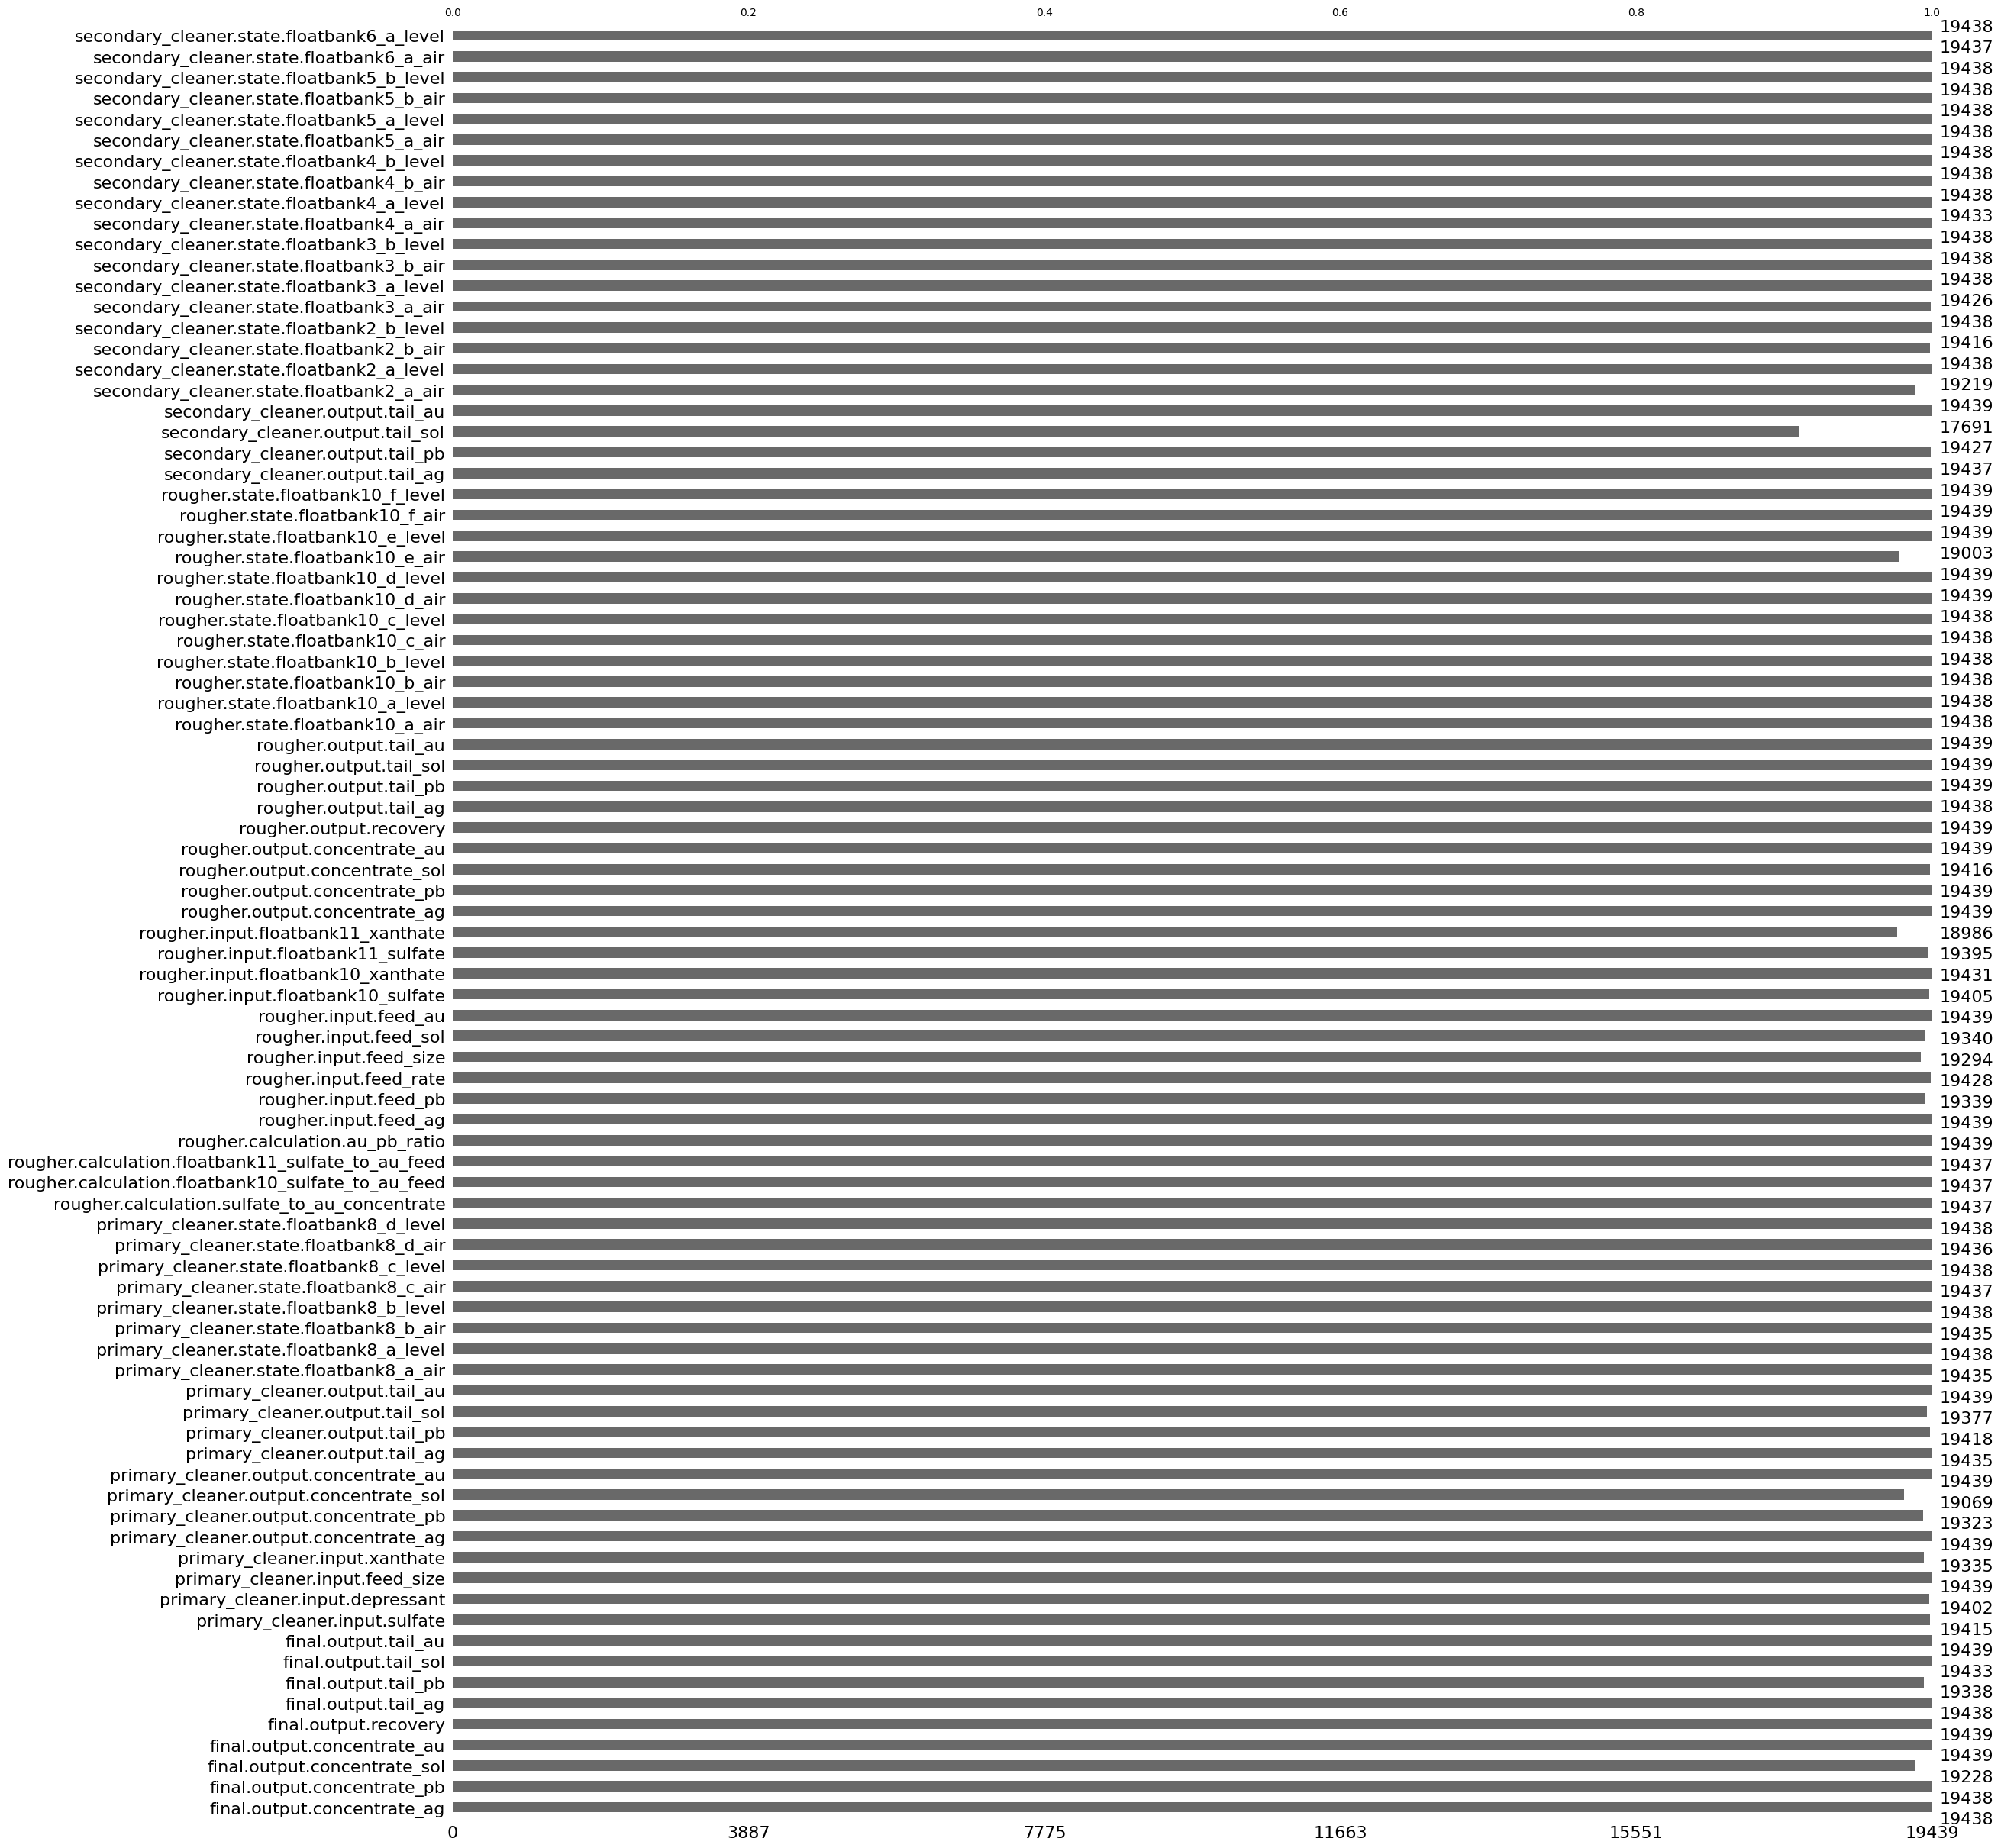

In [9]:
msno.bar(full_data)

In [10]:
# percentage of missing values in the column with the most missing values
full_data['secondary_cleaner.output.tail_sol'].isna().mean().round(4)*100

8.99

**Training sample**

In [11]:
get_data_info(train_data)

<class 'pandas.core.frame.DataFrame'>
Index: 14149 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         14148 non-null  float64
 1   final.output.concentrate_pb                         14148 non-null  float64
 2   final.output.concentrate_sol                        13938 non-null  float64
 3   final.output.concentrate_au                         14149 non-null  float64
 4   final.output.recovery                               14149 non-null  float64
 5   final.output.tail_ag                                14149 non-null  float64
 6   final.output.tail_pb                                14049 non-null  float64
 7   final.output.tail_sol                               14144 non-null  float64
 8   final.output.tail_au                             

None

'SAMPLE:'

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-04-30 03:59:59,4.831718,9.122051,7.795392,47.860043,60.973953,9.463762,1.513932,8.430295,2.140389,105.003214,7.997452,7.203334,1.296431,9.065489,9.469852,11.072859,31.731636,17.938435,3.902418,6.793248,3.357974,1700.887545,-501.109180,1701.647851,-499.326169,1699.670360,-501.325009,1700.331538,-507.470588,38148.934385,2513.067529,2512.449372,2.967716,7.366174,1.727363,587.963996,83.739282,40.510837,5.126323,7.180017,6.943104,7.177347,5.000000,13.160710,6.302774,24.734268,16.260810,89.969835,3.081179,0.426561,23.541450,0.717761,1197.532726,-300.010733,1301.556320,-500.236442,1201.927836,-500.179426,1191.855061,-498.929770,1101.428889,-499.515169,1100.822010,-499.751061,18.219393,8.057984,2.274574,5.205456,34.920332,-500.401115,27.960610,-500.513007,35.990116,-500.191159,25.006856,-500.079465,30.018472,-500.694920,19.909097,-499.551319,25.008186,-500.529198,23.003778,-499.984891,24.979313,-499.888647
2016-04-20 23:00:00,6.974094,11.152241,16.236120,41.914794,77.555688,

'DUPLICATES:'

0

'DESCRIPTION:'

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,14148.000000,14148.000000,13938.000000,14149.000000,14149.000000,14149.000000,14049.000000,14144.000000,14149.000000,14129.000000,14117.000000,14149.000000,14049.000000,14149.000000,14063.000000,13863.000000,14149.000000,14148.000000,14134.000000,14103.000000,14149.000000,14145.000000,14148.000000,14145.000000,14148.000000,14147.000000,14148.000000,14146.000000,14148.000000,1.414800e+04,14148.000000,14148.000000,14149.000000,14149.000000,14049.000000,14141.000000,14005.000000,14071.000000,14149.000000,14120.000000,14141.000000,14113.000000,13721.000000,14149.000000,14149.000000,14127.000000,14149.000000,14149.000000,14148.000000,14149.000000,14149.000000,14149.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14149.000000,14149.000000,13713.000000,14149.000000,14149.000000,14149.000000,14147.000000,14139.000000,12544.000000,14149.000000,13932.000000,14148.000000,14128.000000,14148.000000,14145.000000,14148.000000,14148.000000,14148.000000,14143.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148

**Testing sample**

In [12]:
get_data_info(test_data)

<class 'pandas.core.frame.DataFrame'>
Index: 5290 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Data columns (total 52 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   primary_cleaner.input.sulfate               5286 non-null   float64
 1   primary_cleaner.input.depressant            5285 non-null   float64
 2   primary_cleaner.input.feed_size             5290 non-null   float64
 3   primary_cleaner.input.xanthate              5286 non-null   float64
 4   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 5   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 6   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 8   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_level    5290 non-null

None

'SAMPLE:'

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-12-05 00:59:59,169.219783,8.339161,7.910,1.601907,1547.686765,-500.948922,1548.789947,-510.824135,1553.640353,-498.687318,1549.430722,-500.390390,10.051271,2.980140,665.490674,82.379196,43.774783,9.645313,16.536800,8.198793,16.535779,8.088095,999.291526,-400.223378,1099.685291,-499.943426,1101.075430,-500.018723,1000.993772,-500.283727,1000.311113,-500.695032,900.417807,-499.867116,25.066366,-500.082062,19.823134,-499.633875,29.996224,-500.131531,17.942754,-500.243974,17.017407,-500.196701,15.002135,-136.884344,10.959451,-494.888237,9.028840,-490.774604,17.995895,-497.269901
2016-10-16 22:59:59,209.929831,20.030388,6.650,1.003994,1648.923169,-500.020046,1700.312602,-500.273389,1700.699141,-500.479959,1698.954061,-500.005567,12.449852,4.879433,406.676912,45.432190,35.764863,12.040888,14.995784,7.207293,14.964848,7.194287,1011.381987,-399.987574,1344.287591,-400.111040,1399.808571,-399.927153,1394.227191,-399.702240,1200.422812,-400.658238,1050.727745,-400.076831,30.105700,-500.430815,25.030289,-500.410717,33.016482,-500.217396,30.982412,-500.225975,20.032311,-500.393569,14.978120,-499.246776,8.804194,-500.901176,14.015530,-500.743487,16.979761,-499.879572
2017-09-08 19:59:59,123.842500,4.541136,6.900,1.387064,1599.933834,-498.827753,1599.759927,-499.556249,1598.707206,-500.453070,1600.078191,-500.073844,5.532250,3.780523,449.767196,63.332943,37.603522,6.389337,15.000489,5.498597,15.001078,5.499808,1000.462791,-298.964125,1299.114657,-497.788685,1249.470970,-497.522873,1206.266392,-497.836532,1000.431409,-499.176058,1001.082280,-497.031067,28.004840,-499.990132,20.945932,-500.710859,23.013764,-500.044965,14.953568,-500.016528,11.993697,-500.019072,9.003385,-400.021299,14.008021,-499.800434,8.424569,-500.021367,15.001470,-500.151538
2016-09-21 22:59:59,117.556970,5.544760,8.050,0.848338,1598.131300,-499.566049,1599.250168,-499.979762,1600.072344,-499.824751,1598.533896,-500.034091,9.308596,3.452290,407.568230,46.401673,36.255611,9.479299,7.997458,6.390808,8.000669,6.398179,996.804197,-499.748507,1598.887881,-500.056482,1599.139044,

'DUPLICATES:'

0

'DESCRIPTION:'

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,5286.000000,5285.000000,5290.000000,5286.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5290.000000,5290.000000,5287.000000,5289.000000,5269.000000,5290.000000,5285.000000,5290.000000,5282.000000,5265.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5287.000000,5290.000000,5288.000000,5290.000000,5281.000000,5290.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000
mean,174.839652,8.683596,7.266339,1.383803,1.539494e+03,-497.665883,1.545174e+03,-500.273098,1.527272e+03,-498.330680,1.544844e+03,-500.199527,9.371940,3.798082,489.800620,55.951097,37.716648,9.334682,13.855759,6.467745,13.922328,6.512103,1053.400166,-395.732530,1318.926879,-475.241428,1301.595477,-474.836671,1214.847960,-475.682272,1056.648995,-469.029688,997.949719,-470.482465,26.312630,-502.750897,21.949119,-501.987097,25.402926,-507.490314,2.098211e+01,-506.627916,1.632007e+01,-505.144570,1.373544e+01,-463.349858,12.804186,-501.329122,9.881145,-495.663398,17.304935,-501.793193
std,43.027080,3.072050,0.610219,0.643474,1.167979e+02,19.952431,1.222246e+02,32.968307,1.225380e+02,21.964876,1.247731e+02,31.045257,1.926264,0.954859,108.036326,19.081758,5.491415,1.619521,3.350852,1.065114,3.223769,0.886989,121.139309,91.085505,156.450366,45.649466,171.269667,45.859866,185.763319,47.844967,131.542839,59.325990,128.218869,60.759318,3.429852,28.756505,4.354961,34.582722,6.526457,47.620908,6.736179e+00,44.528673,3.493583e+00,31.427337,3.430484e+00,86.189107,3.026591,17.951495,2.868205,34.535007,4.536544,39.044215
min,2.566156,0.003839,5.650000,0.004984,5.445860e-32,-795.316337,6.647490e-32,-799.997015,4.033736e-32,-799.960571,4.039220e-32,-799.794250,0.568441,0.273677,0.002986,0.046369,1.393488,0.568632,0.001147,0.000568,0.000077,0.006985,-0.042069,-657.949759,-0.721806,-650.245277,-0.056636,-647.544439,-0.992219,-648.390665,-1.982295,-649.267537,-2.593390,-649.949283,0.20

In the test dataset, there are significantly fewer features, and the target variables "rougher.output.recovery" and "final.output.recovery" are missing. We will investigate this further in subsequent steps.

The feature "secondary_cleaner.output.tail_sol" has the highest number of missing values, accounting for 9% of the total (we will handle them later).

### Let's check if the enrichment efficiency has been calculated correctly

Let's make a calculation according to the formula and compare the value with the average of the "rougher.output.recovery" column.

In [13]:
# C — The share of gold in the concentrate after flotation/cleaning.
C = train_data['rougher.output.concentrate_au']

# F — The share of gold in the feed before flotation/cleaning.
F = train_data['rougher.input.feed_au']

# T — The share of gold in the tailings after flotation/cleaning.
T = train_data['rougher.output.tail_au']

train_data["recovery"] = ((C * (F - T)) / (F * (C - T))) * 100
train_data["recovery"].mean()

82.70450164550293

In [14]:
train_data["rougher.output.recovery"].mean()

82.70450164550293

In [15]:
# calculating MAE
mean_absolute_error(train_data["recovery"], train_data["rougher.output.recovery"])

9.73512347450521e-15

In [16]:
# removing the column with calculations
train_data.drop("recovery", axis=1, inplace=True)

The average value of rougher.output.recovery and the manually calculated values coincide, and the MAE value is small - the enrichment efficiency is calculated correctly.

### Let's analyze the features unavailable in the test sample

In [17]:
train_data.columns.symmetric_difference(test_data.columns)

Index(['final.output.concentrate_ag', 'final.output.concentrate_au',
       'final.output.concentrate_pb', 'final.output.concentrate_sol',
       'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_au',
       'final.output.tail_pb', 'final.output.tail_sol',
       'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_au',
       'primary_cleaner.output.tail_pb', 'primary_cleaner.output.tail_sol',
       'rougher.calculation.au_pb_ratio',
       'rougher.calculation.floatbank10_sulfate_to_au_feed',
       'rougher.calculation.floatbank11_sulfate_to_au_feed',
       'rougher.calculation.sulfate_to_au_concentrate',
       'rougher.output.concentrate_ag', 'rougher.output.concentrate_au',
       'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol',
       'roughe

All the unavailable features in the test dataset are related to product parameters and calculated characteristics.

### Data preprocessing

In [18]:
# converting indexes into datetime
for d in all_data:
    d.index = pd.to_datetime(d.index)

In [19]:
# creating a dataframe where test sample is merged with target features
test_with_targets = test_data.merge(full_data.loc[:,["rougher.output.recovery","final.output.recovery"]], on = "date")

In [20]:
# saving the training dataset without features of type "calculation" and "output"
train = train_data[test_with_targets.columns]

In [21]:
# percent of missing values in train sample by column
blanks = train.isna().mean().round(4)*100
blanks.sort_values(ascending=False)

rougher.state.floatbank10_e_air               3.08
rougher.input.floatbank11_xanthate            3.02
secondary_cleaner.state.floatbank2_a_air      1.53
rougher.input.feed_size                       1.02
rougher.input.feed_pb                         0.71
primary_cleaner.input.xanthate                0.71
rougher.input.feed_sol                        0.55
rougher.input.floatbank11_sulfate             0.25
primary_cleaner.input.depressant              0.23
rougher.input.floatbank10_sulfate             0.20
secondary_cleaner.state.floatbank2_b_air      0.15
primary_cleaner.input.sulfate                 0.14
rougher.input.feed_rate                       0.06
rougher.input.floatbank10_xanthate            0.06
secondary_cleaner.state.floatbank4_a_air      0.04
primary_cleaner.state.floatbank8_a_air        0.03
secondary_cleaner.state.floatbank3_a_air      0.03
primary_cleaner.state.floatbank8_b_air        0.03
primary_cleaner.state.floatbank8_d_air        0.02
secondary_cleaner.state.floatba

In [22]:
# deleting missing values in all the columns, as they're amount is insignificant
train.dropna(inplace=True)

In [23]:
# percent of missing values in test sample by column
blanks = test_with_targets.isna().mean().round(4)*100
blanks.sort_values(ascending=False)

rougher.input.floatbank11_xanthate            0.47
rougher.input.feed_sol                        0.40
secondary_cleaner.state.floatbank3_a_air      0.17
rougher.input.floatbank11_sulfate             0.15
primary_cleaner.input.depressant              0.09
rougher.input.floatbank10_sulfate             0.09
primary_cleaner.input.sulfate                 0.08
primary_cleaner.input.xanthate                0.08
rougher.input.feed_rate                       0.06
secondary_cleaner.state.floatbank2_a_air      0.06
secondary_cleaner.state.floatbank2_b_air      0.04
rougher.input.feed_size                       0.02
secondary_cleaner.state.floatbank4_a_level    0.00
secondary_cleaner.state.floatbank3_a_level    0.00
rougher.state.floatbank10_f_level             0.00
rougher.output.recovery                       0.00
secondary_cleaner.state.floatbank6_a_level    0.00
secondary_cleaner.state.floatbank2_a_level    0.00
secondary_cleaner.state.floatbank6_a_air      0.00
secondary_cleaner.state.floatba

In [24]:
# deleting missing values in all the columns, as they're amount is insignificant
test_with_targets.dropna(inplace=True)

## Data analysis

### Let's see how the concentration of metals (Au, Ag, Pb) changes at different stages of processing:

- Rougher — flotation
- Primary_cleaner — primary cleaning
- Secondary_cleaner — secondary cleaning
- Final — final characteristics

In [25]:
# concentrations in the original dataframe
full_data_nonan = full_data.dropna()

In [26]:
print("Concentrations before flotation", f'gold: {full_data_nonan["rougher.input.feed_au"].mean()}', f'silver: {full_data_nonan["rougher.input.feed_ag"].mean()}', f'lead: {full_data_nonan["rougher.input.feed_pb"].mean()}', sep='\n')
print()
print("Concentrations after flotation", f'gold: {full_data_nonan["rougher.output.concentrate_au"].mean()}', f'silver: {full_data_nonan["rougher.output.concentrate_ag"].mean()}', f'lead: {full_data_nonan["rougher.output.concentrate_pb"].mean()}', sep='\n')
print()
print("Concentrations after primary cleaning", f'gold: {full_data_nonan["primary_cleaner.output.concentrate_au"].mean()}', f'silver: {full_data_nonan["primary_cleaner.output.concentrate_ag"].mean()}', f'lead: {full_data_nonan["primary_cleaner.output.concentrate_pb"].mean()}', sep='\n')
print()
print("Concentrations after secondary cleaning", f'gold: {full_data_nonan["final.output.concentrate_au"].mean()}', f'silver: {full_data_nonan["final.output.concentrate_ag"].mean()}', f'lead: {full_data_nonan["final.output.concentrate_pb"].mean()}', sep='\n')

Concentrations before flotation
gold: 8.516990259152191
silver: 8.985280730057909
lead: 3.6366213175766076

Concentrations after flotation
gold: 20.05215197989563
silver: 12.084944858379451
lead: 7.553095191381346

Concentrations after primary cleaning
gold: 32.06555911061983
silver: 8.674852987693988
lead: 9.884018203488715

Concentrations after secondary cleaning
gold: 44.30743739837964
silver: 5.190975683404247
lead: 9.997593468101922


- The concentration of gold increases with each stage and exceeds the initial concentration by more than five times at the final stage.

- The concentration of silver increases after flotation but decreases at the subsequent stages, reaching 58% of the initial value.

- The concentration of lead increases with each stage and almost triples the initial concentration at the final stage.

### Let's compare the distributions of the feed size in the training and test datasets.

If the distributions significantly differ from each other, the model evaluation could be incorrect. We will create a plot to visualize the comparison.

[Text(0.5, 1.0, 'Feed Size Distributions'),
 Text(0.5, 0, 'Datasets'),
 Text(0, 0.5, 'Size'),
 [Text(0, 0, 'Training Dataset'), Text(1, 0, 'Test Dataset')]]

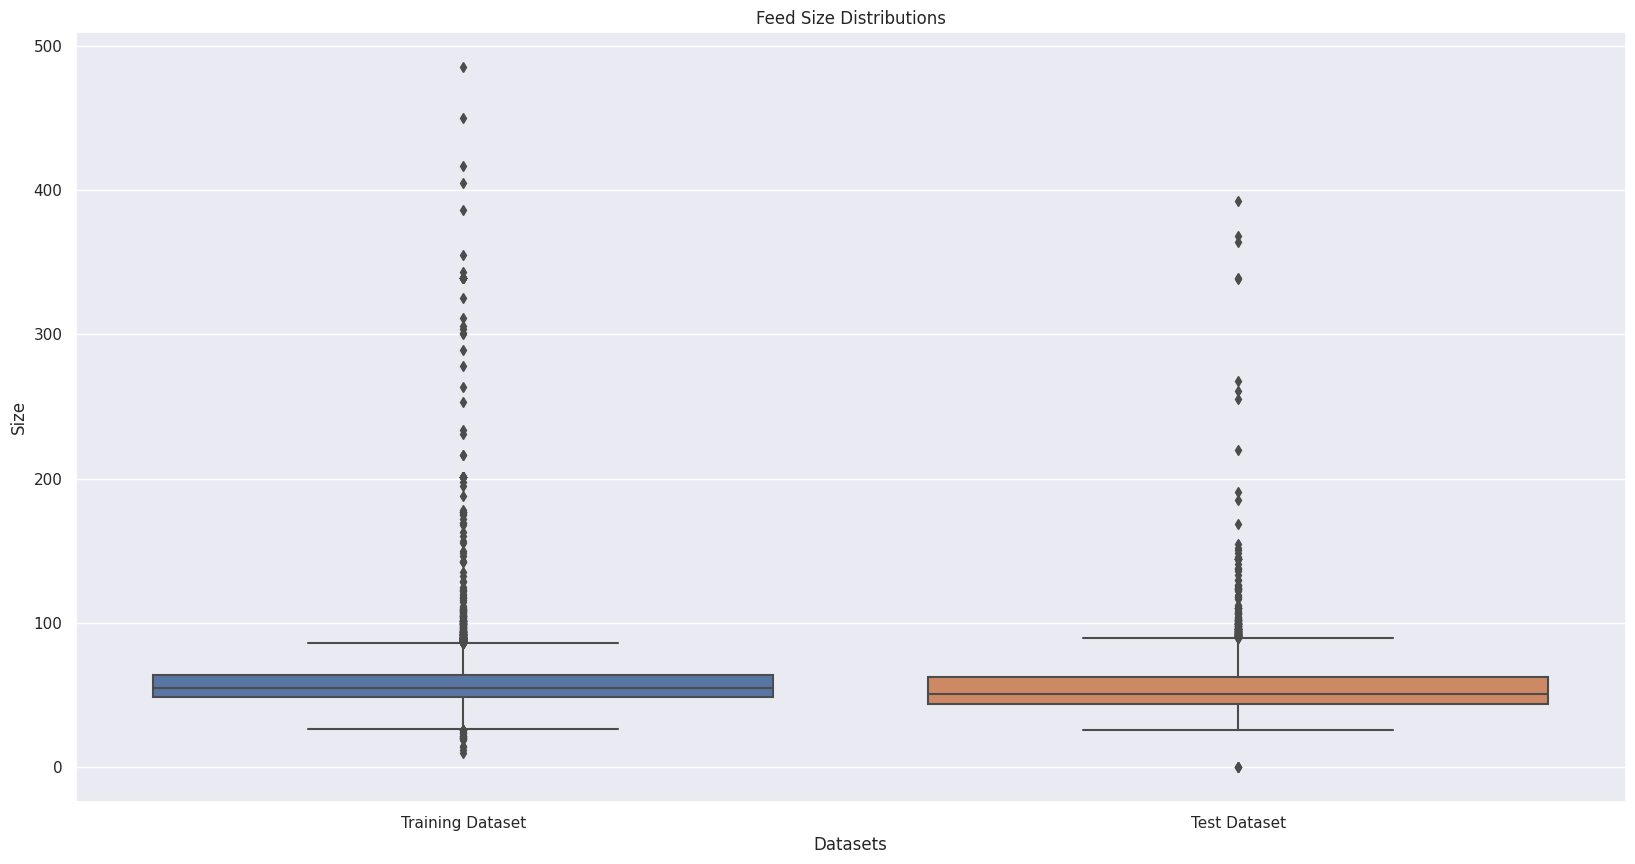

In [27]:
sns.set(rc={"figure.figsize":(20, 10)})
p = sns.boxplot(data=[train["rougher.input.feed_size"], test_with_targets["rougher.input.feed_size"]])
p.set(title='Feed Size Distributions', xlabel = "Datasets", ylabel="Size", xticklabels = ["Training Dataset", "Test Dataset"])


In [28]:
display(train["rougher.input.feed_size"].describe())
test_with_targets["rougher.input.feed_size"].describe()

count    12679.000000
mean        58.414412
std         20.441275
min          9.659576
25%         48.721041
50%         54.651129
75%         63.719220
max        484.967466
Name: rougher.input.feed_size, dtype: float64

count    5229.000000
mean       55.863978
std        18.914656
min         0.046369
25%        43.911874
50%        50.772729
75%        62.265394
max       392.494040
Name: rougher.input.feed_size, dtype: float64

The distribution of feed size in both datasets is generally comparable, except for some outliers: in the test dataset, the minimum value is zero, while in the training dataset, there are values around 500.

### Let's investigate the total concentration of all substances at different stages: in the feed, rougher concentrate, and final concentrate (au, ag, pb, sol).

In [29]:
# total concentration of all substances before flotation
conc_rougher = full_data_nonan[['rougher.input.feed_ag',
                                 'rougher.input.feed_pb',
                                 'rougher.input.feed_sol',
                                 'rougher.input.feed_au']].sum(axis=1)

In [30]:
# total concentration of all substances after flotation
conc_post_rougher = full_data_nonan[['rougher.output.concentrate_pb',
                   'rougher.output.concentrate_ag',
                   'rougher.output.concentrate_sol',
                   'rougher.output.concentrate_au']].sum(axis=1)

In [31]:
# total concentration of all substances in the final concentrate
conc_final = full_data_nonan[['final.output.concentrate_pb',
                   'final.output.concentrate_ag',
                   'final.output.concentrate_sol',
                   'final.output.concentrate_au']].sum(axis=1)

Text(0.5, 0, 'Total concentration')

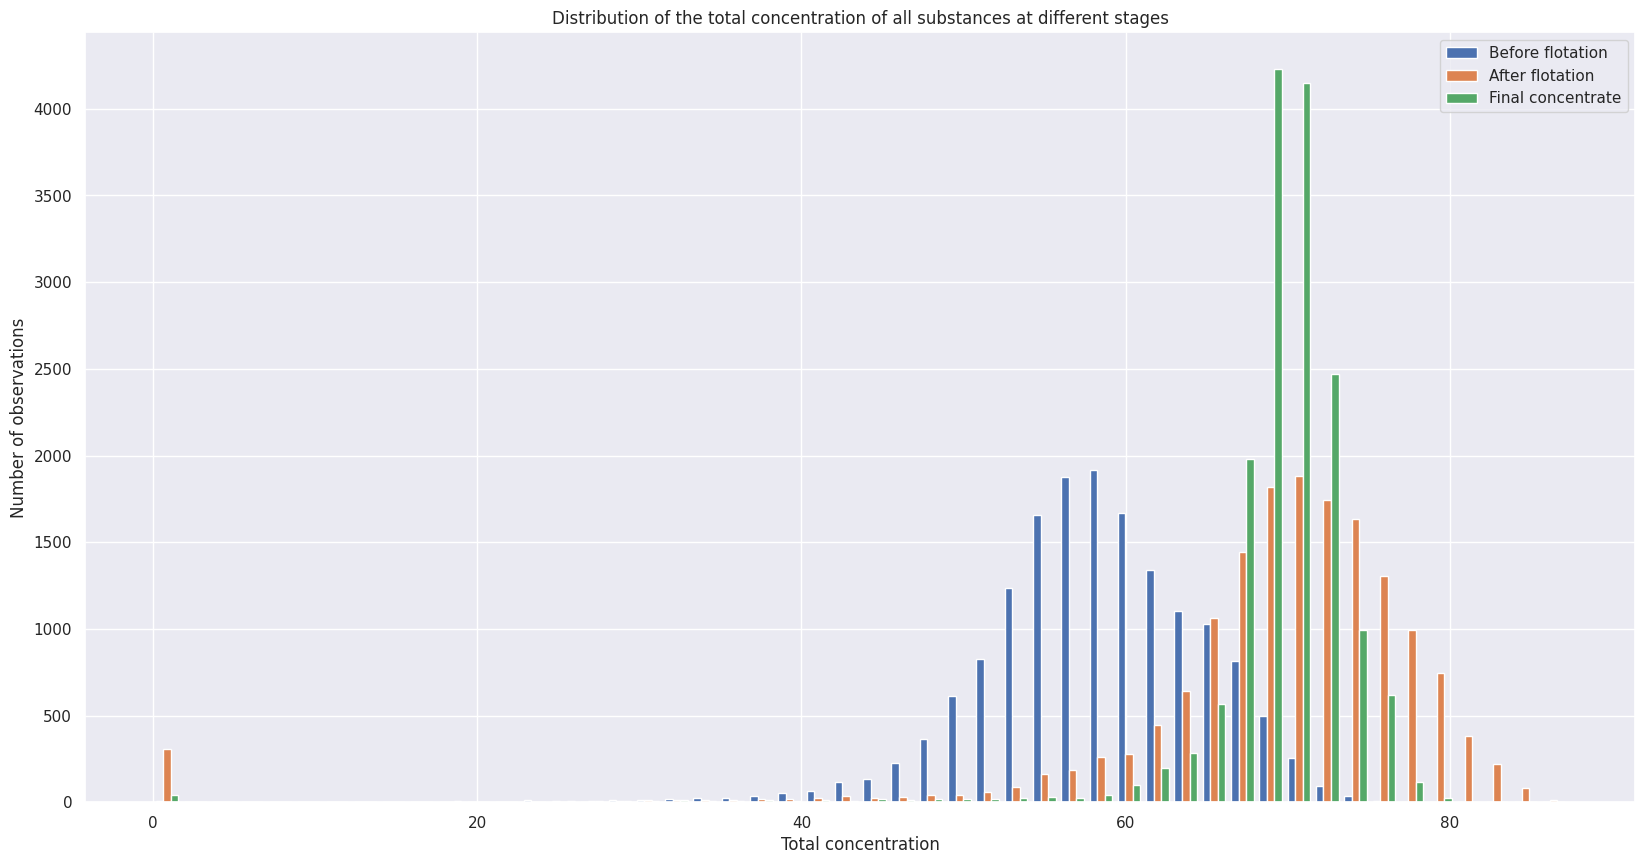

In [32]:
# distributions plot
plt.hist([conc_rougher, conc_post_rougher, conc_final], bins=50)
plt.legend(["Before flotation", "After flotation", "Final concentrate"])
plt.title(label="Distribution of the total concentration of all substances at different stages")
plt.ylabel("Number of observations")
plt.xlabel("Total concentration")

The total concentration increases at each stage. In the final concentrate, there are peaks around the value of 70. It can also be observed that "outliers" near zero appear during the processing of the raw material - we will get rid of them.

In [33]:
# deleting zero values
train = train.drop(index = train[train["rougher.input.feed_au"] < 1].index,
                               axis = 0)
train = train.drop(index = train[train["rougher.input.feed_ag"] < 1].index,
                               axis = 0)
train = train.drop(index = train[train["rougher.input.feed_pb"] < 1].index,
                               axis = 0)
train = train.drop(index = train[train["rougher.input.feed_sol"] < 1].index,
                               axis = 0)

## Model

### Data Preparation

Let's take a closer look at the correlation between features in the datasets, as well as extract targets and features for the training and testing datasets.

In [34]:
# function for calculating correlation with the target
def corr_matrix(df, col):
    df.corr()[[col]].sort_values(by=col, ascending=False)
    plt.figure(figsize=(8, 12))
    heatmap = sns.heatmap(df.corr()[[col]].sort_values(by=col, ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
    heatmap.set_title('Features  сorrelating with '+col, fontdict={'fontsize':18}, pad=16);

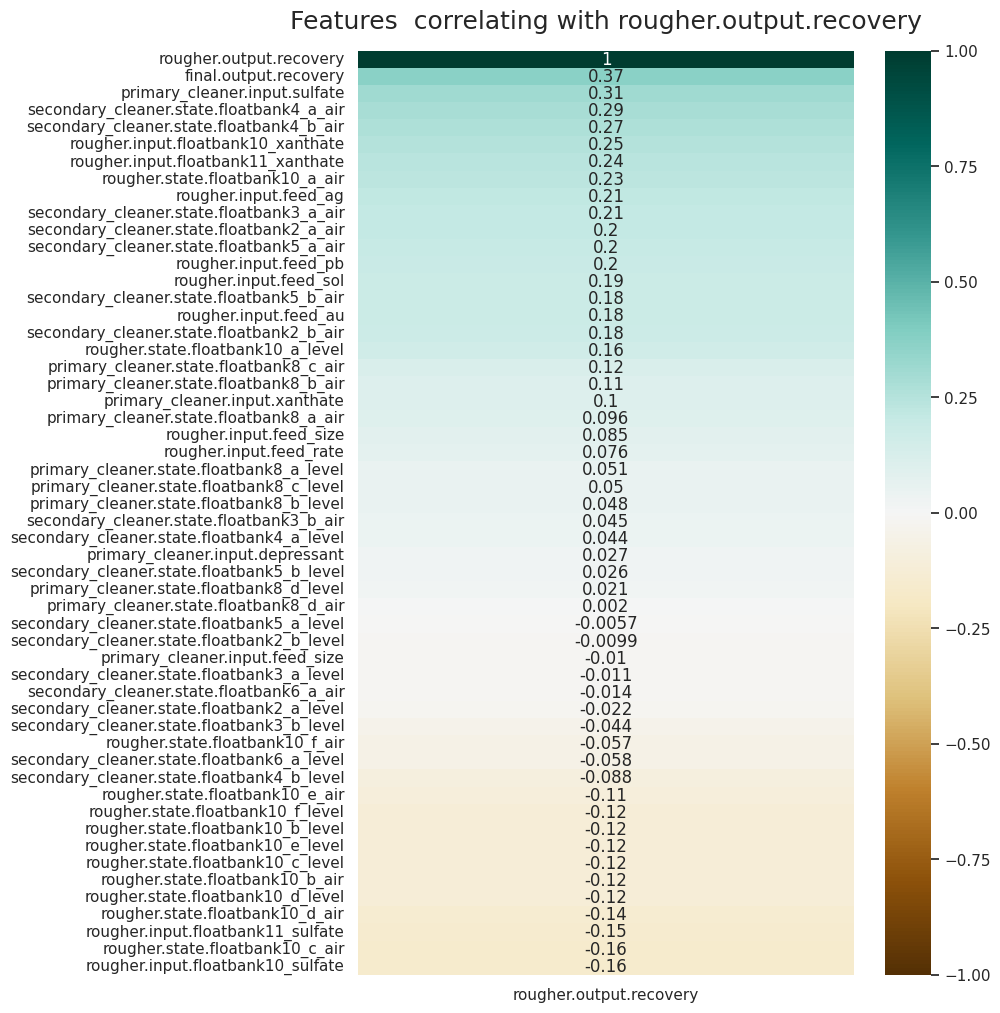

In [35]:
# let's see which features are most correlated with `rougher.output.recovery`.
corr_matrix(train, "rougher.output.recovery")

In [36]:
# splitting training sample
target_train_rougher = train['rougher.output.recovery']

# leaving only features with correlation over 0.2
features_train_rougher = train[['final.output.recovery',
                    'primary_cleaner.input.sulfate',
                    'secondary_cleaner.state.floatbank4_a_air',
                    'secondary_cleaner.state.floatbank4_b_air',
                    'rougher.input.floatbank10_xanthate',
                    'rougher.input.floatbank11_xanthate']]

# splitting test sample
target_test_rougher = test_with_targets['rougher.output.recovery']

# leaving only features with correlation over 0.2
features_test_rougher = test_with_targets[['final.output.recovery',
                    'primary_cleaner.input.sulfate',
                    'secondary_cleaner.state.floatbank4_a_air',
                    'secondary_cleaner.state.floatbank4_b_air',
                    'rougher.input.floatbank10_xanthate',
                    'rougher.input.floatbank11_xanthate']]

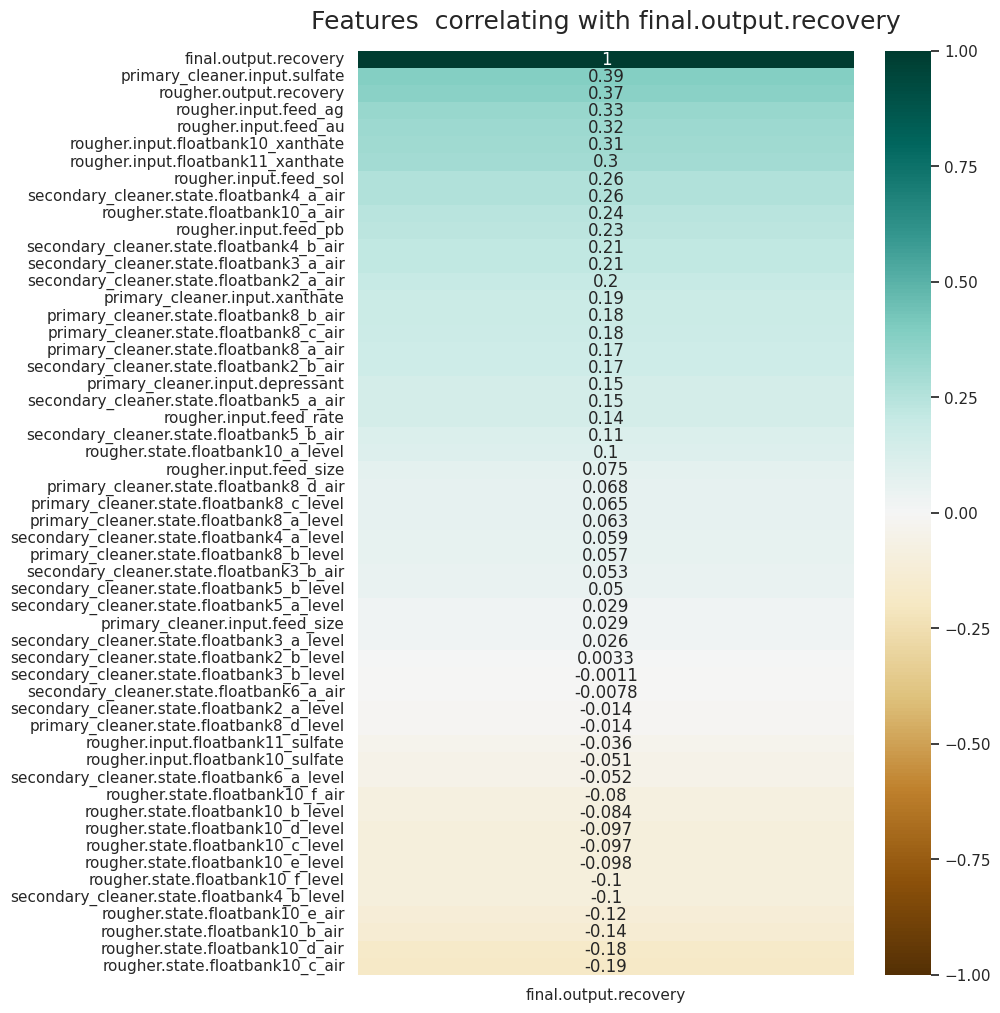

In [37]:
# let's see which features are most correlated with final.output.recovery
corr_matrix(train, "final.output.recovery")

In [38]:
# splitting training sample
target_train_final = train['final.output.recovery']

# leaving only features with correlation over 0.2
features_train_final = train[['primary_cleaner.input.sulfate',
                    'rougher.input.floatbank10_xanthate',
                    'rougher.output.recovery',
                    'rougher.input.floatbank11_xanthate',
                    'rougher.input.feed_ag',
                    'rougher.input.feed_au',
                    'rougher.input.feed_sol',
                    'rougher.state.floatbank10_a_air',
                    'secondary_cleaner.state.floatbank4_a_air',
                    'primary_cleaner.input.xanthate',
                    'secondary_cleaner.state.floatbank3_a_air',
                    'rougher.input.feed_pb']]

# splitting test sample
target_test_final = test_with_targets['final.output.recovery']

# leaving only features with correlation over 0.2
features_test_final = test_with_targets[['primary_cleaner.input.sulfate',
                    'rougher.input.floatbank10_xanthate',
                    'rougher.output.recovery',
                    'rougher.input.floatbank11_xanthate',
                    'rougher.input.feed_ag',
                    'rougher.input.feed_au',
                    'rougher.input.feed_sol',
                    'rougher.state.floatbank10_a_air',
                    'secondary_cleaner.state.floatbank4_a_air',
                    'primary_cleaner.input.xanthate',
                    'secondary_cleaner.state.floatbank3_a_air',
                    'rougher.input.feed_pb']]

### Let's create a function that calculates the final sMAPE

In [39]:
# function that calculates sMAPE
def sMAPE(target, pred):
    error = np.mean(abs(target - pred)/((abs(target) + abs(pred))/2)) * 100
    return error

In [40]:
# function that calculates the final sMAPE
def final_sMAPE(sMAPE_rougher, sMAPE_final):
    error = 0.25 * sMAPE_rougher + 0.75 * sMAPE_final
    return error

In [41]:
# custom scorer
smape_score = make_scorer(sMAPE, greater_is_better=False)

### We will train different models and evaluate their quality using cross-validation

Let's consider the Random Forest and Extreme Gradient Boosting models, applying feature scaling beforehand. We will use RandomizedSearchCV for hyperparameter tuning.

In [42]:
# model initialization
model_rf = make_pipeline(StandardScaler(), RandomForestRegressor())
model_hgb = make_pipeline(StandardScaler(), HistGradientBoostingRegressor())

# params for RandomizedSearchCV
params_rf = {"randomforestregressor__n_estimators": [10, 50, 100],
             "randomforestregressor__max_depth": [3, 5, 8, 10]}
params_hgb = {"histgradientboostingregressor__max_depth": [2, 2.5, 3, 3.5, 4, 5],
             "histgradientboostingregressor__learning_rate": [0.1, 0.05, 0.01, 0.005]}

grid_rougher_rf = RandomizedSearchCV(model_rf, param_distributions = params_rf, scoring=smape_score, random_state=RANDOM_STATE)
grid_final_rf = RandomizedSearchCV(model_rf, param_distributions = params_rf, scoring=smape_score, random_state=RANDOM_STATE)
grid_rougher_hgb = RandomizedSearchCV(model_hgb, param_distributions = params_hgb, scoring=smape_score, random_state=RANDOM_STATE)
grid_final_hgb = RandomizedSearchCV(model_hgb, param_distributions = params_hgb, scoring=smape_score, random_state=RANDOM_STATE)

####  Model training with a target "rougher.output.recovery"

In [43]:
# RandomForestRegressor
grid_rougher_rf.fit(features_train_rougher, target_train_rougher)
smape_rougher_rf = grid_rougher_rf.best_score_
print("Best sMAPE:", grid_rougher_rf.best_score_)
print("Best params:", grid_rougher_rf.best_params_)

Best sMAPE: -9.333220797745225
Best params: {'randomforestregressor__n_estimators': 50, 'randomforestregressor__max_depth': 5}


In [44]:
# HistGradientBoostingRegressor
grid_rougher_hgb.fit(features_train_rougher, target_train_rougher)
smape_rougher_hgb = grid_rougher_hgb.best_score_
print("Best sMAPE:", grid_rougher_hgb.best_score_)
print("Best params:", grid_rougher_hgb.best_params_)

Best sMAPE: -8.876298928989018
Best params: {'histgradientboostingregressor__max_depth': 3, 'histgradientboostingregressor__learning_rate': 0.05}


#### Model training with a target "final.output.recovery"

In [45]:
# RandomForestRegressor
grid_final_rf.fit(features_train_final, target_train_final)
smape_final_rf = grid_final_rf.best_score_
print("Best sMAPE:", grid_final_rf.best_score_)
print("Best params:", grid_final_rf.best_params_)

Best sMAPE: -8.117989376800043
Best params: {'randomforestregressor__n_estimators': 50, 'randomforestregressor__max_depth': 5}


In [46]:
# HistGradientBoostingRegressor
grid_final_hgb.fit(features_train_final, target_train_final)
smape_final_hgb = grid_final_hgb.best_score_
print("Best sMAPE:", grid_final_hgb.best_score_)
print("Best params:", grid_final_hgb.best_params_)

Best sMAPE: -8.194172353993038
Best params: {'histgradientboostingregressor__max_depth': 4, 'histgradientboostingregressor__learning_rate': 0.1}


The HistGradientBoostingRegressor showed the best results for all target features. Let's calculate the final sMAPE for both models.

In [47]:
print("RandomForestRegressor final sMAPE:", final_sMAPE(smape_rougher_rf, smape_final_rf))
print("HistGradientBoostingRegressor final sMAPE:", final_sMAPE(smape_rougher_hgb, smape_final_hgb))

RandomForestRegressor final sMAPE: -8.421797232036338
HistGradientBoostingRegressor final sMAPE: -8.364703997742032


The final sMAPE is slightly better for the HistGradientBoostingRegressor. Let's apply it to the test dataset.

#### Additionally testing CatBoostRegressor model

In [48]:
pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 5.5 MB/s eta 0:00:00


In [49]:
pip install ipywidgets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 9.8 MB/s eta 0:00:00


In [50]:
from catboost import CatBoostRegressor

# model initialization
model_cat = make_pipeline(StandardScaler(), CatBoostRegressor())

# params for RandomizedSearchCV
params_cat = {'catboostregressor__learning_rate': [0.03, 0.1],
              'catboostregressor__depth': [4, 6, 10],
              'catboostregressor__l2_leaf_reg': [1, 3, 5, 7, 9]}


grid_rougher_cat = RandomizedSearchCV(model_cat, param_distributions = params_cat, scoring=smape_score, random_state=RANDOM_STATE)
grid_final_cat = RandomizedSearchCV(model_cat, param_distributions = params_cat, scoring=smape_score, random_state=RANDOM_STATE)

In [51]:
# CatBoostRegressor for rougher.output.recovery
grid_rougher_cat.fit(features_train_rougher, target_train_rougher)
smape_rougher_cat = grid_rougher_cat.best_score_
print("Best sMAPE:", grid_rougher_cat.best_score_)
print("Best params:", grid_rougher_cat.best_params_)

Streaming output truncated to the last 5000 lines.
2:	learn: 12.5641962	total: 10.5ms	remaining: 3.5s
3:	learn: 12.2957786	total: 14.3ms	remaining: 3.56s
4:	learn: 12.0243114	total: 17.7ms	remaining: 3.52s
5:	learn: 11.8057580	total: 21.2ms	remaining: 3.5s
6:	learn: 11.6170319	total: 24.5ms	remaining: 3.48s
7:	learn: 11.4494598	total: 27.8ms	remaining: 3.45s
8:	learn: 11.3200691	total: 31.1ms	remaining: 3.43s
9:	learn: 11.1968521	total: 34.4ms	remaining: 3.4s
10:	learn: 11.0937790	total: 37.8ms	remaining: 3.4s
11:	learn: 11.0063899	total: 42.4ms	remaining: 3.49s
12:	learn: 10.9344949	total: 45.6ms	remaining: 3.46s
13:	learn: 10.8667467	total: 48.7ms	remaining: 3.43s
14:	learn: 10.7967633	total: 52ms	remaining: 3.41s
15:	learn: 10.7484037	total: 55.2ms	remaining: 3.4s
16:	learn: 10.6964907	total: 58.6ms	remaining: 3.39s
17:	learn: 10.6463108	total: 61.8ms	remaining: 3.37s
18:	learn: 10.6027728	total: 65.3ms	remaining: 3.37s
19:	learn: 10.5626938	total: 68.2ms	remaining: 3.34s
20:	learn:

In [52]:
# CatBoostRegressor for final.output.recovery
grid_final_cat.fit(features_train_final, target_train_final)
smape_final_cat = grid_final_cat.best_score_
print("Best sMAPE:", grid_final_cat.best_score_)
print("Best params:", grid_final_cat.best_params_)

Streaming output truncated to the last 5000 lines.
2:	learn: 9.0136329	total: 15ms	remaining: 4.97s
3:	learn: 8.9339346	total: 19.9ms	remaining: 4.96s
4:	learn: 8.8578644	total: 24.8ms	remaining: 4.94s
5:	learn: 8.7735505	total: 29.8ms	remaining: 4.93s
6:	learn: 8.6958035	total: 34.6ms	remaining: 4.91s
7:	learn: 8.6193038	total: 39.4ms	remaining: 4.88s
8:	learn: 8.5491348	total: 45.9ms	remaining: 5.06s
9:	learn: 8.4776371	total: 50.6ms	remaining: 5.01s
10:	learn: 8.4130067	total: 55.9ms	remaining: 5.02s
11:	learn: 8.3536333	total: 61ms	remaining: 5.02s
12:	learn: 8.2923618	total: 66.2ms	remaining: 5.03s
13:	learn: 8.2324930	total: 71.2ms	remaining: 5.01s
14:	learn: 8.1763733	total: 76.1ms	remaining: 4.99s
15:	learn: 8.1245157	total: 82.1ms	remaining: 5.05s
16:	learn: 8.0750488	total: 86.9ms	remaining: 5.02s
17:	learn: 8.0235714	total: 93.1ms	remaining: 5.08s
18:	learn: 7.9729787	total: 104ms	remaining: 5.37s
19:	learn: 7.9248090	total: 109ms	remaining: 5.33s
20:	learn: 7.8830668	total:

In [53]:
print("Catboostregressor final sMAPE:", final_sMAPE(smape_rougher_cat, smape_final_cat))

Catboostregressor final sMAPE: -8.34001711052381


#### Additionally testing ElasticNet model

In [54]:
from sklearn.linear_model import ElasticNet

# model initialization
model_en = make_pipeline(StandardScaler(), ElasticNet())

# params for RandomizedSearchCV
params_en = {'elasticnet__alpha': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0],
              'elasticnet__l1_ratio': [0, 1, 0.01]}

grid_rougher_en = RandomizedSearchCV(model_en, param_distributions = params_en, scoring=smape_score, random_state=RANDOM_STATE)
grid_final_en = RandomizedSearchCV(model_en, param_distributions = params_en, scoring=smape_score, random_state=RANDOM_STATE)

In [55]:
# ElasticNet for rougher.output.recovery
grid_rougher_en.fit(features_train_rougher, target_train_rougher)
smape_rougher_en = grid_rougher_en.best_score_
print("Best sMAPE:", grid_rougher_en.best_score_)
print("Best params:", grid_rougher_en.best_params_)

Best sMAPE: -8.687033153744618
Best params: {'elasticnet__l1_ratio': 0.01, 'elasticnet__alpha': 0.01}


In [56]:
# ElasticNet for final.output.recovery
grid_final_en.fit(features_train_final, target_train_final)
smape_final_en = grid_final_en.best_score_
print("Best sMAPE:", grid_final_en.best_score_)
print("Best params:", grid_final_en.best_params_)

Best sMAPE: -9.216324123899497
Best params: {'elasticnet__l1_ratio': 1, 'elasticnet__alpha': 0.001}


In [57]:
print("Elasticnet final sMAPE:", final_sMAPE(smape_rougher_en, smape_final_en))

Elasticnet final sMAPE: -9.084001381360778


#### Testing the best model on test sample

In [58]:
# predicting the target features of the test dataset using the best model
rougher_test = grid_rougher_hgb.predict(features_test_rougher)
final_test = grid_final_hgb.predict(features_test_final)

In [59]:
# final sMAPE on test sample
final_sMAPE(sMAPE(target_test_rougher, rougher_test), sMAPE(target_test_final, final_test))

8.000794725154801

 Let's compare the results with a dummy model.

In [60]:
# training the dummy
dummy_rough = DummyRegressor(strategy="median")
dummy_final = DummyRegressor(strategy="median")

dummy_rough.fit(features_train_rougher, target_train_rougher)
dummy_final.fit(features_train_final, target_train_final)

DummyRegressor(strategy='median')

# predictions
dummy_rougher_pred = dummy_rough.predict(features_test_rougher)
dummy_final_pred = dummy_final.predict(features_test_final)

# calculating final sMAPE
final_sMAPE(sMAPE(target_test_rougher, dummy_rougher_pred), sMAPE(target_test_final, dummy_final_pred))

9.080836124446476

The sMAPE of the final model is better than that of the constant model, so we can consider the model to be adequate.

Conclusions
- To prepare a model for effectively predicting the gold recovery coefficient from gold-bearing ore, we considered RandomForestRegressor and HistGradientBoostingRegressor with the selection of features with the highest correlation and their scaling.
- We obtained the final symmetric mean absolute percentage error (sMAPE) for RandomForestRegressor, which was 8.45 for the training dataset.
- The sMAPE for HistGradientBoostingRegressor on the training dataset was 8.19.
Due to the better result on the training data, we applied HistGradientBoostingRegressor to the test dataset, achieving a result of 7.8 sMAPE.
- The sMAPE of HistGradientBoostingRegressor outperformed the result of the dummy model (9.08), confirming the reasonableness of the final model.